# Featout implementation

In [15]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from scipy.signal import convolve2d

#### Gradient-based method to infer the attention of a model on an image

In [2]:
from captum.attr import Saliency

def simple_gradient_saliency(net, input_img, label):
    """
    Simplest interpretable method
    Takes an image and computes the gradients
    """
    initial_input = input_img.clone()
    # activate gradients
    initial_input.requires_grad = True
    net.eval()
    # saliency method --> can use other method here
    saliency = Saliency(net)
    grads = saliency.attribute(initial_input, target=label)
    return grads



### Zero-out feature

This is the code to find the maximum coordinates of the activation and "delete" a patch around these coordinates.

In [3]:
def get_max_activation(gradients, filter_size=3):
    """
    Get the coordinates where the activation is maximal
    Includes smoothing with an all-ones filter of size filter_size
    """
    grads_mean = np.mean(gradients, axis=0)
    # smooth the results to avoid using outlier activation
    filtered = convolve2d(
        grads_mean,
        np.ones((filter_size, filter_size)),
        mode="same",
    )
    # get max of smoothed array
    max_act = np.argmax(filtered.flatten())
    # get corresponding x and y coordinates
    max_x = max_act // grads_mean.shape[1]
    max_y = max_act % grads_mean.shape[1]
    return max_x, max_y
    
def zero_out(img, max_coordinates, patch_radius=4):
    """
    Zero out a quadratic patch around max_coordinates with a Gaussian filter
    """
    max_x, max_y = max_coordinates
    modified_input = img.clone()
    modified_input[:, :, max_x - patch_radius:max_x + patch_radius + 1,
                   max_y - patch_radius:max_y + patch_radius + 1] = 0
    return modified_input

### FEATOUT dataset

This is the core of the pipeline, a torch Dataset class that applies featout in the `__getitem__` method. In other words, everytime that a new batch is sampled, the  `__getitem__` method from this dataset is called. If featout is activated (class attribute `featout=True`), then the method applies an attention mechanism to find the features with highest activation, and blurs the feature.

In [11]:

class Featout(torch.utils.data.Dataset):
    """
    Inspired from https://discuss.pytorch.org/t/changing-transformation-applied-to-data-during-training/15671/3
    Example usage:
    dataset = Featout(normal arguments of super dataset)
    loader = DataLoader(dataset, batch_size=2, num_workers=2, shuffle=True)
    loader.dataset.start_featout(net)
    """

    def __init__(
        self, dataset, plotting_path, *args, **kwargs
    ):
        """
        Args:
            dataset: torch Dataset object (must impelemnt getitem and len)
        """
        # actual dataset
        self.dataset = dataset
        # initial stage: no blurring
        self.featout = False
        # set path where to save plots (set to None if no plotting desired)
        self.plotting = plotting_path

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Main workflow: Get image, if label correct, then featout (blur/zero)
        and return the modified image
        """
        # call method from base dataset
        image, label = self.dataset.__getitem__(index)

        if self.featout:
            in_img = torch.unsqueeze(image, 0)

            # run a prediction with the given model --> TODO: this can be done
            # more efficiently by passing the predicted labels from the
            # preceding epoch to this class
            _, predicted_lab = torch.max(
                self.featout_model(in_img).data, 1
            )
            # only do featout if it was predicted correctly
            if predicted_lab == label:
                # get model attention via gradient based method
                gradients = self.algorithm(
                    self.featout_model, in_img, label
                )[0].numpy()
                # Compute point of maximum activation
                max_x, max_y = get_max_activation(gradients)

                # blur patch at activation (feat-out)
                blurred_image = self.blur_method(
                    in_img, (max_x, max_y), patch_radius=4
                )
                # save images before and after if plotting is desired
                if PLOTTING is not None:
                    new_grads = self.algorithm(
                        self.featout_model,
                        blurred_image,
                        label,
                    )[0].numpy()
                    plot_together(
                        image,
                        gradients,
                        blurred_image[0],
                        new_grads
                    )

                image = blurred_image[0]

        return image, label

    def start_featout(
        self,
        model,
        blur_method=zero_out,
        algorithm=simple_gradient_saliency,
    ):
        """
        We can set here whether we want to blur or zero and what gradient alg
        """
        print("\n STARTING FEATOUT \n ")
        self.featout = True
        self.algorithm = algorithm
        self.featout_model = model
        self.blur_method = blur_method

    def stop_featout(self):
        self.featout = False



### Plotting
Here is some code that we use for visualizing what featout does during the epoch


In [17]:

def transform_cifar(img):
    """for cifar, we need to transform the images"""
    return np.transpose(
        (img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0)
    )

def img_to_npy(img):
    return img.squeeze().cpu().detach().numpy()


def get_overlayed_img(image, gradients):
    """
    Normalize gradients and overlay image with them (red channel)
    """
    normed_gradients = np.mean(gradients, axis=0)
    normed_gradients = (
        normed_gradients - np.min(normed_gradients)
    ) / (
        np.max(normed_gradients) - np.min(normed_gradients)
    )
    # Take image in greyscale
    transformed = transform_cifar(image)
    overlayed = np.tile(
        np.expand_dims(
            np.mean(transformed, axis=2).copy(), 2
        ),
        (1, 1, 3),
    )
    # colour the gradients red
    overlayed[:, :, 0] = normed_gradients
    return overlayed


def plot_together(
    image,
    gradients,
    blurred_image,
    new_grads,
    save_path="outputs/test.png",
):
    """
    Plot four images: the original one, then overlayed by gradients, then the
    blurred one, then this one overlayed by the new gradients
    """
    # get the points of max activation
    max_x, max_y = get_max_activation(gradients)
    new_max_x, new_max_y = get_max_activation(new_grads)
    # Make figure
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(img_to_npy(image))
    plt.title("Original input image")
    plt.subplot(1, 4, 2)
    plt.imshow(get_overlayed_img(image, gradients))
    plt.title(
        f"Model attention BEFORE blurring (max at x={max_x}, y={max_y})"
    )
    plt.subplot(1, 4, 3)
    plt.imshow(img_to_npy(blurred_image))
    plt.title("Modified input image (blurred)")
    plt.subplot(1, 4, 4)
    plt.imshow(get_overlayed_img(blurred_image, new_grads))
    plt.title(
        f"Model attention AFTER blurring (max at x={max_x}, y={max_y})"
    )
    plt.show()



## Run pipeline

We are now ready to put everything together. This code trains on the MNIST dataset and starts and stops featout inbetween.

In [13]:
DATASET = torchvision.datasets.MNIST  # CIFAR10
# method how to remove features - here by default blurring
BLUR_METHOD = zero_out
# algorithm to derive the model's attention
ATTENTION_ALGORITHM = simple_gradient_saliency
# set this path to some folder, e.g., "outputs", if you want to plot the results
PLOTTING = True

Epoch 1, samples  2000] loss: 2.082
Epoch 1, samples  4000] loss: 1.755
Epoch 1, samples  6000] loss: 1.726
Epoch 1, samples  8000] loss: 1.704
Epoch 1, samples 10000] loss: 1.700
Epoch 1, samples 12000] loss: 1.698
Epoch 1, samples 14000] loss: 1.700
time for epoch: 40.587242126464844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy of the network on the test images: 86 %

 STARTING FEATOUT 
 


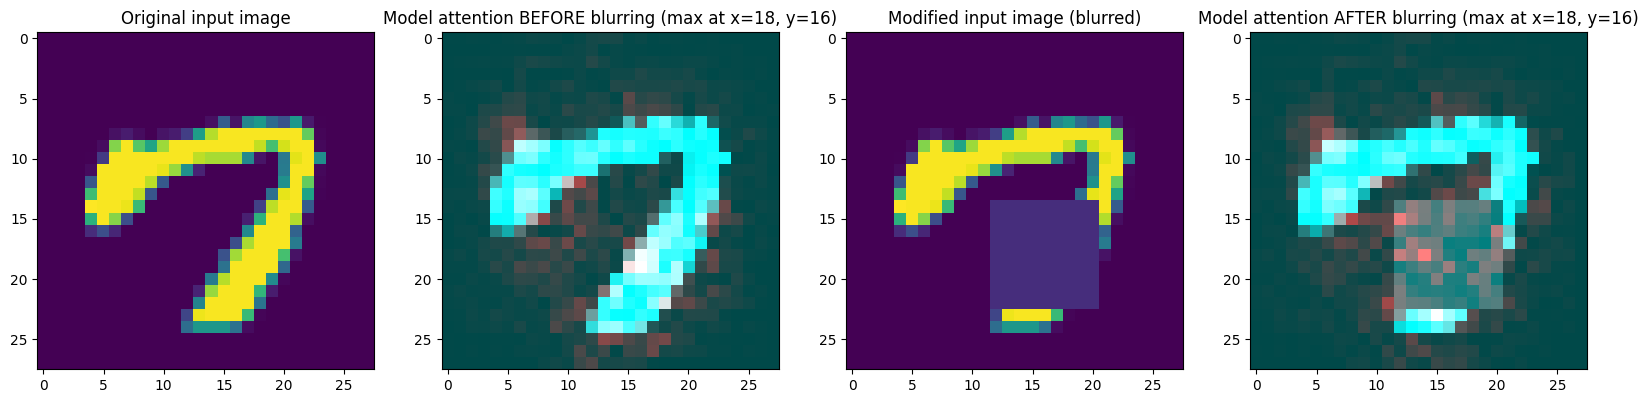

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


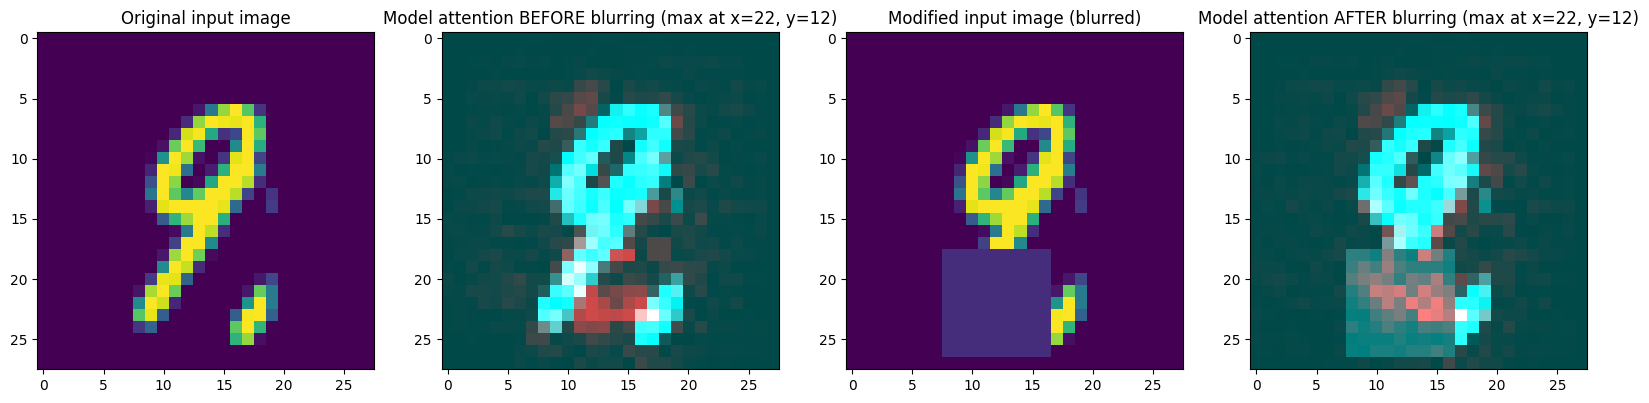

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


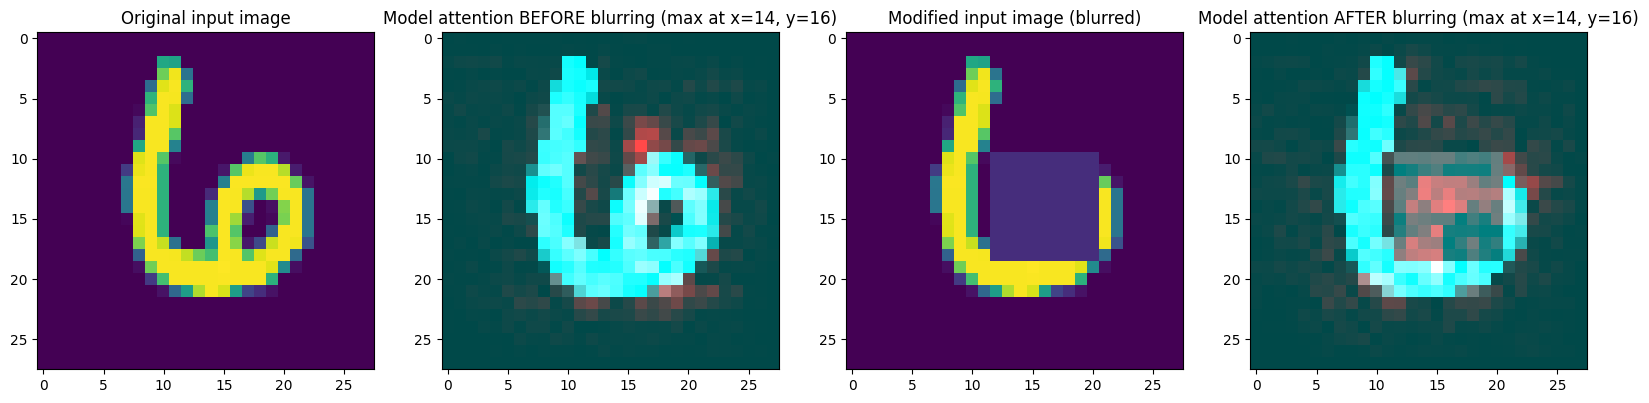

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [19]:


# augmentation
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        # for cifar: (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# load the original dataset (it's downloaded automatically if not found)
original_trainset = DATASET(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
# wrap the dataset with featout
trainset = Featout(original_trainset, None)

# the trainloader handles batching of the training set
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=0
)
# for the test data, we don't need any transformations, so we take the original
# dataset and put it into the dataloader (without shuffling)
testset = DATASET(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=0
)

# define a simple CNN
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(160, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 160)
        # x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# define model and optimizer (standard mnist model from torch is used)
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), lr=0.001, momentum=0.9
)

for epoch in range(2):
    tic = time.time()
    running_loss = 0.0
    blurred_set = []

    # START FEATOUT
    # TODO: decide when to start featout, or only every second epoch?
    if epoch > 0:
        trainloader.dataset.start_featout(
            net,
            blur_method=BLUR_METHOD,
            algorithm=ATTENTION_ALGORITHM,
        )

    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (
            i % 2000 == 1999
        ):  # print every 2000 mini-batches
            print(
                "Epoch %d, samples %5d] loss: %.3f"
                % (epoch + 1, i + 1, running_loss / 2000)
            )
            running_loss = 0.0

    print(f"time for epoch: {time.time()-tic}")

    # Evaluate test performance
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(
        "Accuracy of the network on the test images: %d %%"
        % (100 * correct / total)
    )

    # stop featout after every epoch
    trainloader.dataset.stop_featout()

# Save model
print("Finished Training")
torch.save(
    net.state_dict(), "trained_models/cifar_torchvision.pt"
)

